In [ ]:
!pip install wandb --upgrade

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, random
from tqdm.notebook import tqdm
from IPython import display
from datetime import datetime

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
from torchmetrics import MetricCollection, Accuracy, Precision, Recall, AUROC, ConfusionMatrix
import pytorch_lightning as pl

from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Загрузка датасета

In [2]:
import os.path

# Путь к таблице
PATH_TO_TABLE = 'data_fullness.xlsx'
data = pd.read_excel(PATH_TO_TABLE, header=0)

data = data.drop(columns=['Дата вывоза', 'Общий путь к фото', 
                          'Относительный путь к фото', 'Ответственный'], errors='ignore')
data = data.drop(index=[35686, 35687], errors='ignore')
data['Путь к фото контейнера'] = data.apply(lambda x: x['Путь к фото контейнера'].split('/')[-1], axis=1)

# Путь к папке с файлами
ROOT = 'data/'
inaccessible_indices = []
for index, row in data.iterrows():
    path = row['Путь к фото контейнера']
    if os.path.isfile(ROOT + path) is False:
        inaccessible_indices.append(index)

data = data.drop(index=inaccessible_indices, errors='ignore')

Процент наполнения
0     2346
1     3554
2     3806
3    16569
4     9398
Name: Контейнерная площадка, dtype: int64

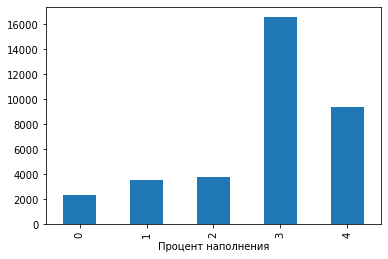

In [3]:
def match_weight_5(row):
    weight = row['Процент наполнения']
    if weight <= 25:
        return 0 #20
    elif 25 < weight <= 50:
        return 1 #40
    elif 50 < weight <= 75:
        return 2 #60
    elif 75 < weight <= 100:
        return 3 #100
    elif weight > 100:
        return 4 #140

data['Процент наполнения'] = data.apply(match_weight_5, axis=1)
data.groupby(by='Процент наполнения').count()['Контейнерная площадка'].plot(kind='bar')
data.groupby(by='Процент наполнения').count()['Контейнерная площадка']

width $\in$ [300,1632], height $\in$ [300,1632]

### Предобработка датасета, создание даталоадера

In [4]:
class PolygonWeightDataset(Dataset):
    """Custom Polygon Dataset dataset."""

    def __init__(self, data, root_dir, return_name=False, transform=None):
        """
        Args:
            data (pd.DataFrame):
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.root_dir = root_dir
        self.transform = transform
        self.return_name = return_name 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, self.data.loc[idx,'Путь к фото контейнера'])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed['image']

        label = torch.tensor(float(self.data.loc[idx,'Процент наполнения']))
        label = label.long()      
        
        if self.return_name:
            return image, label, img_name
        else:
            return image, label

In [5]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.15, random_state=24) # 0.15 for test set
data_train, data_val = train_test_split(data_train, test_size=0.18, random_state=24) # 0.18 x 0.85 = 0.153 for vaidation set

data_train = data_train.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2


val_transform = A.Compose([
    A.RandomResizedCrop(224, 224, scale=(0.6, 1.0)),
    A.Normalize(max_pixel_value=1.0),
    ToTensorV2(),
])

# скорее всего, можно подобрать набор аугментаций лучше, чем этот
train_transform = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.GaussNoise(p=1.0),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.Sharpen(),
            A.Emboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
        A.RandomResizedCrop(224, 224, scale=(0.6, 1.0)),
        A.Normalize(max_pixel_value=1.0),
        ToTensorV2(),
    ])

train_dataset = PolygonWeightDataset(data_train, ROOT, transform=train_transform)
val_dataset = PolygonWeightDataset(data_val, ROOT, transform=val_transform)
test_dataset = PolygonWeightDataset(data_test, ROOT, transform=val_transform)

batch_size = 60
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=32, 
                              pin_memory=True)
val_dataloader = DataLoader(val_dataset, 
                            batch_size=batch_size, 
                            shuffle=False, 
                            num_workers=32, 
                            pin_memory=True)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size, 
                             shuffle=False, 
                             num_workers=32, 
                             pin_memory=True)

### Модель

In [6]:
import pytorch_lightning as pl
import seaborn as sns
from PIL import Image
import io


class MobileNetv3_WeightDefiner(pl.LightningModule):
    def __init__(self, num_features_fc=1280, num_classes=7, lr=1e-3, freeze=True):
        super(MobileNetv3_WeightDefiner, self).__init__()
        
        # Architecture
        self.num_classes = num_classes
        
        mobilenet = models.mobilenet_v3_large(pretrained=True)
        mobilenet._modules.pop('classifier')
        self.mobilenet_features = nn.Sequential(mobilenet._modules)
        mobilenet = None
        
        if freeze:
            for name, param in self.mobilenet_features.named_parameters():
                param.requires_grad = False     

        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=960, out_features=num_features_fc, bias=True),
            nn.Hardswish(),
            nn.Dropout(p=0.35),
            nn.Linear(num_features_fc, num_classes)
        )
        
        # Initialise loss
        self.loss = nn.CrossEntropyLoss(weight=torch.Tensor([3.0451929 , 1.99710843, 1.89151769, 0.42928177, 0.76176471]))
        
        # Metrics
        self.train_precision = Precision(num_classes=num_classes, average=None)
        self.train_recall = Recall(num_classes=num_classes, average=None)
        self.train_mean_acc = Accuracy()
        
        self.valid_conf_matrix = ConfusionMatrix(num_classes=num_classes)
        self.valid_precision = Precision(num_classes=num_classes, average=None)
        self.valid_recall = Recall(num_classes=num_classes, average=None)
        self.valid_mean_acc = Accuracy()
        
        # save hyper-parameters to self.hparams (auto-logged by W&B)
        self.save_hyperparameters()
        self.lr = lr

        
    def forward(self, x):
        x = self.mobilenet_features(x) # out: [batch_size, 1280, 1, 1]
        x = torch.flatten(x, 1) # out: [batch_size, 1280]
        x = self.linear_layers(x) # out: [batch_size, num_classes]
        return x

    
    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.loss(logits, labels)
        
        # logs metrics for each training_step and the average across the epoch (to the progress bar and logger)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.train_precision(logits, labels)
        self.train_recall(logits, labels)
        self.train_mean_acc(logits, labels)
        return loss
    
    
    def training_epoch_end(self, outs):
        train_precision = self.train_precision.compute()
        train_recall = self.train_recall.compute()
        train_mean_acc = self.train_mean_acc.compute()
        for i in range(self.num_classes):
            self.log(f'train_recall_{i}', train_recall[i])
            self.log(f'train_precision_{i}', train_precision[i])
        self.log('train_acc', train_mean_acc)


            
    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.loss(logits, labels)
        
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.valid_conf_matrix(logits, labels)
        self.valid_precision(logits, labels)
        self.valid_recall(logits, labels)
        self.valid_mean_acc(logits, labels)

        
    def validation_epoch_end(self, validation_step_outputs):
        valid_conf_matrix = self.valid_conf_matrix.compute().detach().cpu().numpy().astype(int)
        valid_precision = self.valid_precision.compute()
        valid_recall = self.valid_recall.compute()
        valid_mean_acc = self.valid_mean_acc.compute()
        
        for i in range(self.num_classes):
            self.log(f'valid_recall_{i}', valid_recall[i])
            self.log(f'valid_precision_{i}', valid_precision[i])
        self.log('valid_acc', valid_mean_acc)
        
        df_cm = pd.DataFrame(
            valid_conf_matrix,
            index=['true <25', 'true <50', 'true <75', 'true <100', 'true >100'], 
            columns=['<25', '<50', '<75', '<100', '>100'], 
            ) 
        plt.figure(figsize = (10,7))
        fig_ = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Spectral').get_figure()
        plt.close(fig_)
        wandb.log({"confusion_matrix": [wandb.Image(fig_, caption="Confusion matrix")]})
    
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=40, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

### Обучение сетки

In [7]:
import wandb
from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor

# sets seeds for numpy, torch, python.random and PYTHONHASHSEED.
# seed_everything(42, workers=True)

# init model
weight_definer = MobileNetv3_WeightDefiner(num_classes=5, lr=0.004)

# Wandb logging
wandb_logger = WandbLogger(project='big3_weight', entity='nali', log_model='all') # здесь надо будет заменить название проекта и ник
lr_monitor = LearningRateMonitor(logging_interval='step')

# Checkpointing
checkpoint_callback = ModelCheckpoint(
    monitor="valid_acc",
    dirpath="checkpoints/",
    filename="5cl-best-acc-{epoch:02d}-{valid_acc:.2f}",
    save_top_k=1,
    mode="max",
)

# training the model
trainer = pl.Trainer(deterministic=False,
                     gpus=1, 
                     logger=wandb_logger, 
                     max_epochs=100,
                     callbacks=lr_monitor, # надо заменить на callbacks=[checkpoint_callback, lr_monitor], если нужно сохранить веса
                     num_sanity_val_steps=0,
                    )


trainer.fit(weight_definer, train_dataloader, val_dataloader)

wandb.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: nali (use `wandb login --relogin` to force relogin)



  | Name               | Type             | Params
--------------------------------------------------------
0 | mobilenet_features | Sequential       | 3.0 M 
1 | linear_layers      | Sequential       | 1.2 M 
2 | loss               | CrossEntropyLoss | 0     
3 | train_precision    | Precision        | 0     
4 | train_recall       | Recall           | 0     
5 | train_mean_acc     | Accuracy         | 0     
6 | valid_conf_matrix  | ConfusionMatrix  | 0     
7 | valid_precision    | Precision        | 0     
8 | valid_recall       | Recall           | 0     
9 | valid_mean_acc     | Accuracy         | 0     
--------------------------------------------------------
1.2 M     Trainable params
3.0 M     Non-trainable params
4.2 M     Total params
16.834    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/maxim/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


epoch,▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁
train_acc,▁
train_loss,▁
train_precision_0,▁
train_precision_1,▁
train_precision_2,▁
train_precision_3,▁
train_precision_4,▁
train_recall_0,▁
train_recall_1,▁


### Подбор значения learning rate

In [ ]:
from pytorch_lightning import seed_everything

# sets seeds for numpy, torch, python.random and PYTHONHASHSEED.
seed_everything(42, workers=True)

# init model
weight_definer = MobileNetv3_WeightDefiner(num_classes=5, lr=1e-3)


# training the model
trainer = pl.Trainer(deterministic=True,
                     auto_lr_find=True,
                     gpus=1, 
                     max_epochs=100,
                     num_sanity_val_steps=0,
                     stochastic_weight_avg=True)

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(weight_definer, train_dataloader, val_dataloader)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
print(lr_finder.suggestion())

# To-do:
* проверить все данные на наличие битых картинок: влияют ли они на итоговые метрики?
* добавить реализацию поэтапного обучения: сначала только последние слои и затем следующим этапом обучение всей сети (разморозка нескольких слоев) - https://pytorch-lightning.readthedocs.io/en/stable/starter/introduction_guide.html#transfer-learning
* сделать поиск по гиперпараметрам
* проверить работу андерсэмплинга (уменьшить 3ий класс)